In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchviz import make_dot


# Setup

In [2]:
ETFtickers=['SPY','GLD','OIL','EWJ','XLK','QQQ','IVV','VTI','USO', 'BOND','IWM']
Stocktickers= ['AAPL','ADBE','AMZN','BAC','IBM','MSFT','INTC', 'GOOGL','NFLX','NVDA','QCOM','TWTR','WFC','BA','C','JPM','TSLA']

In [3]:
# for i in itertools.chain(Stocktickers,ETFtickers):
#     try:
        
#         tickerdata=yf.download(i,group_by="ticker",  start="2015-01-02", end="2022-01-01")
#         tickerdata['ticker'] = i
#         tickerdata.to_csv(f'ticker_{i}.csv')
#     except KeyError:
#         print ('ERROR') 
    
#     print

In [4]:
def eda(df):
    
    ticker = df['ticker'].unique()
    print(ticker)
    df = df.drop(columns=['ticker'])

    # Plot Adjusted Close
    plt.figure(figsize=(12, 6))
    plt.plot(df['Adj Close'], label='Adjusted Close', color='blue')
    plt.title(f'Adjusted Close Price Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots\Adjusted Close Price Over Time for {ticker}')
    plt.show()

    # Plot Volume
    plt.figure(figsize=(12, 6))
    plt.plot(df['Volume'], label='Volume', color='orange')
    plt.title(f'Volume Traded Over Time for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid()
    plt.savefig(f'plots\Volume Traded Over Time for {ticker}')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix for {ticker}')
    plt.savefig(f'plots\Correlation Matrix for {ticker}')
    plt.show()
    print('---------------------------------------------------------------------------------')

In [5]:
def modify(df):
    # Calculate Daily Returns
    df['Daily Return'] = df['Adj Close'].pct_change()

    # Calculate Volatility (20-day rolling standard deviation of daily returns)
    df['Volatility'] = df['Daily Return'].rolling(window=20).std()

    # Label Market Regimes
    df['Regime'] = 'Unknown'  # Initialize regime column

    for i in range(20, len(df)):
        recent_prices = df['Adj Close'].iloc[i-20:i]
        recent_return = (recent_prices.iloc[-1] - recent_prices.iloc[0]) / recent_prices.iloc[0]
        
        # Bull and Bear market conditions
        if recent_return > 0.05:
            df.at[df.index[i], 'Regime'] = 'Bull'
        elif recent_return < -0.05:
            df.at[df.index[i], 'Regime'] = 'Bear'
        elif -0.05 <= recent_return <= 0.05:
            df.at[df.index[i], 'Regime'] = 'Sideways'
        
        # Volatile market condition
        if df['Volatility'].iloc[i] > 0.02:
            df.at[df.index[i], 'Regime'] = 'Volatile'
        
        # Crisis condition
        if df['Daily Return'].iloc[i] < -0.10:
            df.at[df.index[i], 'Regime'] = 'Crisis'

    return df

In [6]:
modified_dfs = []

p = Path('dataset/')
files = list(p.glob('ticker_*.csv'))

for file in files:
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # eda(df)  # Perform exploratory data analysis
    modified_df = modify(df)  # Modify the DataFrame
    modified_dfs.append(modified_df)  # Append modified DataFrame to the list

# Combine all modified DataFrames into a single DataFrame
combined_df = pd.concat(modified_dfs)

In [7]:
combined_df

,Open,High,Low,Close,Adj Close,Volume,ticker,Daily Return,Volatility,Regime
Date,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.347174,212818400,AAPL,NaN,NaN,Unknown
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.661272,257142000,AAPL,-0.028172,NaN,Unknown
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.663504,263188400,AAPL,0.000094,NaN,Unknown
2015-01-07,26.799999,27.049999,26.674999,26.937500,23.995316,160423600,AAPL,0.014022,NaN,Unknown
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.917265,237458000,AAPL,0.038422,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,173.630005,176.690002,173.589996,176.649994,172.528656,6633300,XLK,0.021453,0.018287,Sideways
2021-12-28,176.979996,177.039993,175.289993,175.729996,171.630127,5711100,XLK,-0.005208,0.017643,Sideways
2021-12-29,175.789993,176.589996,174.970001,175.880005,171.776642,4843900,XLK,0.000854,0.017482,Sideways


In [8]:
combined_df = combined_df[combined_df['Regime'] != 'Unknown']

In [9]:
combined_df.shape

(47061, 10)

In [10]:
combined_df.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
ticker          0
Daily Return    0
Volatility      0
Regime          0
dtype: int64

In [11]:
combined_df = combined_df.dropna()
combined_df.shape

(47061, 10)

In [12]:
combined_df['Regime'].value_counts()

Regime
Sideways    24819
Volatile    10795
Bull         8381
Bear         2984
Crisis         82
Name: count, dtype: int64

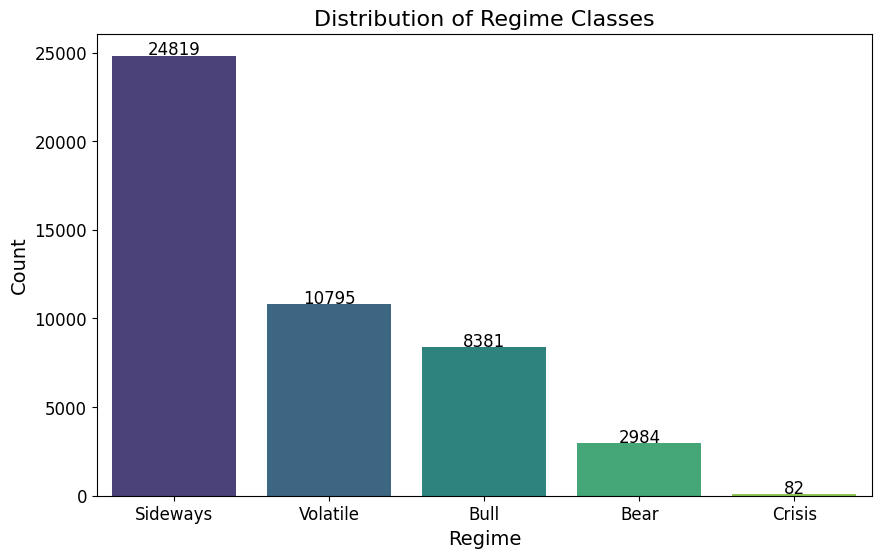

In [13]:
# Count the occurrences of each regime
regime_counts = combined_df['Regime'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=regime_counts.index, y=regime_counts.values, palette='viridis')

# Add labels and title
plt.xlabel('Regime', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Regime Classes', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the values on top of each bar
for i, value in enumerate(regime_counts.values):
    plt.text(i, value + 50, str(value), ha='center', fontsize=12)

# Save plot
plt.savefig('plots\Distribution of Regime Classes.png') 

# Display the plot
plt.show()

In [14]:
combined_df = combined_df.drop(columns=['ticker'])

In [15]:
combined_df

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility,Regime
Date,,,,,,,,,
2015-02-02,29.512501,29.792500,29.020000,29.657499,26.418226,250956400,0.012547,0.023813,Volatile
2015-02-03,29.625000,29.772499,29.402500,29.662500,26.422686,207662800,0.000169,0.022588,Volatile
2015-02-04,29.625000,30.127501,29.577499,29.889999,26.625334,280598800,0.007669,0.022551,Volatile
2015-02-05,30.004999,30.057501,29.812500,29.985001,26.815376,168984800,0.007138,0.022477,Volatile
2015-02-06,30.004999,30.062500,29.612499,29.732500,26.589561,174826400,-0.008421,0.021310,Volatile
...,...,...,...,...,...,...,...,...,...
2021-12-27,173.630005,176.690002,173.589996,176.649994,172.528656,6633300,0.021453,0.018287,Sideways
2021-12-28,176.979996,177.039993,175.289993,175.729996,171.630127,5711100,-0.005208,0.017643,Sideways
2021-12-29,175.789993,176.589996,174.970001,175.880005,171.776642,4843900,0.000854,0.017482,Sideways


In [38]:
# Label encode Regime
le = LabelEncoder()
combined_df['Regime'] = le.fit_transform(combined_df['Regime']) 
combined_df

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility,Regime
Date,,,,,,,,,
2015-02-02,29.512501,29.792500,29.020000,29.657499,26.418226,250956400,0.012547,0.023813,4
2015-02-03,29.625000,29.772499,29.402500,29.662500,26.422686,207662800,0.000169,0.022588,4
2015-02-04,29.625000,30.127501,29.577499,29.889999,26.625334,280598800,0.007669,0.022551,4
2015-02-05,30.004999,30.057501,29.812500,29.985001,26.815376,168984800,0.007138,0.022477,4
2015-02-06,30.004999,30.062500,29.612499,29.732500,26.589561,174826400,-0.008421,0.021310,4
...,...,...,...,...,...,...,...,...,...
2021-12-27,173.630005,176.690002,173.589996,176.649994,172.528656,6633300,0.021453,0.018287,3
2021-12-28,176.979996,177.039993,175.289993,175.729996,171.630127,5711100,-0.005208,0.017643,3
2021-12-29,175.789993,176.589996,174.970001,175.880005,171.776642,4843900,0.000854,0.017482,3


In [39]:
# After fitting the LabelEncoder
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("Class to Encoding Mapping:")
for class_name, encoding in class_mapping.items():
    print(f"{class_name} -> {encoding}")


Class to Encoding Mapping:
Bear -> 0
Bull -> 1
Crisis -> 2
Sideways -> 3
Volatile -> 4


In [ ]:
# Convert to numerical
for col in combined_df.columns:
    if combined_df[col].dtype == 'object' and col != 'Regime':  # If the column is of object type and not 'Regime'
        print(col)
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

Volume


In [18]:
combined_df

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility,Regime
Date,,,,,,,,,
2015-02-02,29.512501,29.792500,29.020000,29.657499,26.418226,250956400,0.012547,0.023813,4
2015-02-03,29.625000,29.772499,29.402500,29.662500,26.422686,207662800,0.000169,0.022588,4
2015-02-04,29.625000,30.127501,29.577499,29.889999,26.625334,280598800,0.007669,0.022551,4
2015-02-05,30.004999,30.057501,29.812500,29.985001,26.815376,168984800,0.007138,0.022477,4
2015-02-06,30.004999,30.062500,29.612499,29.732500,26.589561,174826400,-0.008421,0.021310,4
...,...,...,...,...,...,...,...,...,...
2021-12-27,173.630005,176.690002,173.589996,176.649994,172.528656,6633300,0.021453,0.018287,3
2021-12-28,176.979996,177.039993,175.289993,175.729996,171.630127,5711100,-0.005208,0.017643,3
2021-12-29,175.789993,176.589996,174.970001,175.880005,171.776642,4843900,0.000854,0.017482,3


(47061, 9)


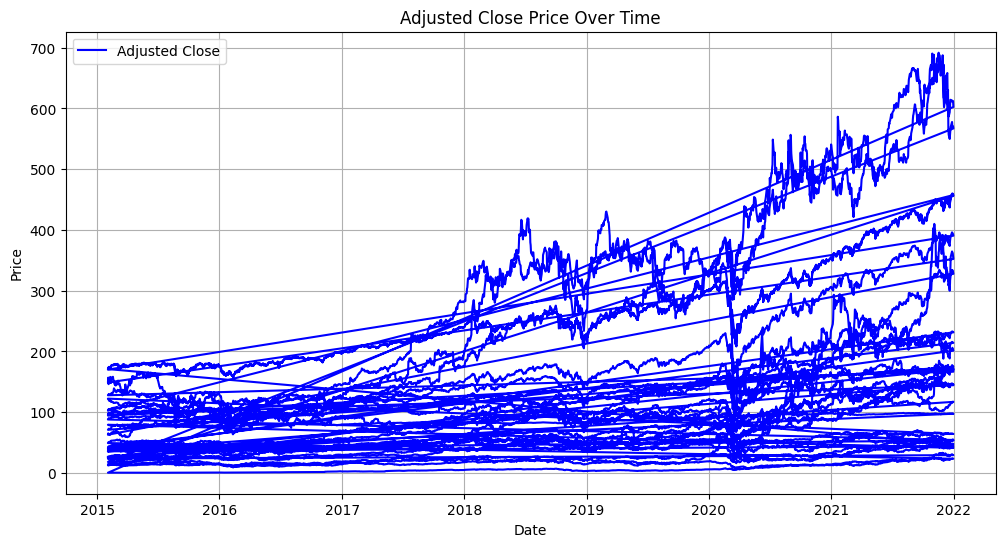

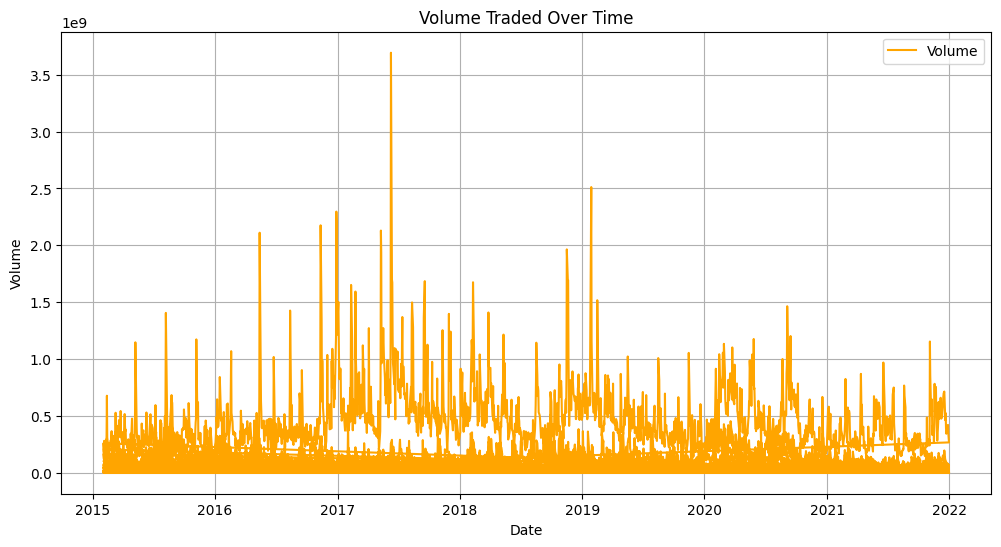

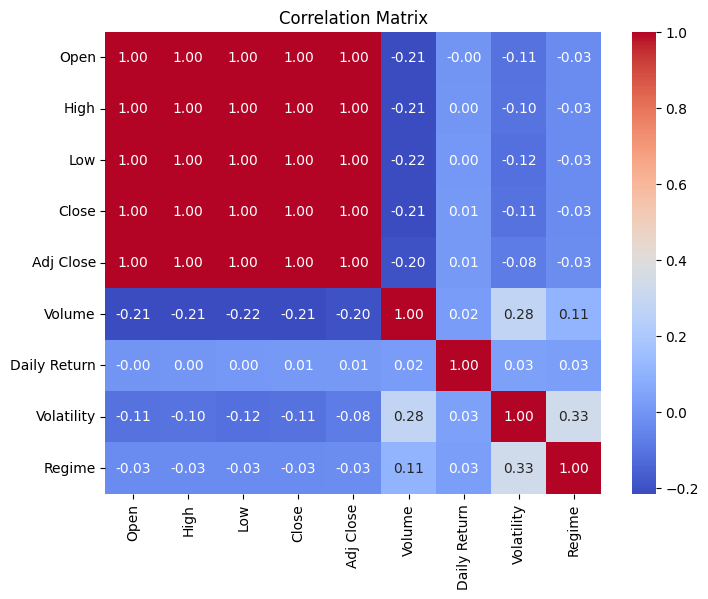

In [ ]:
# Compplete df eda
eda(combined_df)

In [ ]:
# Select numerical columns to normalize, excluding 'Regime'
numerical_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'Regime']  # Exclude 'Regime'

# Scaling numerical columns
scaler = StandardScaler()
combined_df[numerical_cols] = scaler.fit_transform(combined_df[numerical_cols])

combined_df

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2015-02-02 -0.851477 -0.850481 -0.854687 -0.850187  -0.820049  1.869345   
2015-02-03 -0.850409 -0.850669 -0.851018 -0.850140  -0.820005  1.472904   
2015-02-04 -0.850409 -0.847331 -0.849339 -0.847980  -0.818042  2.140782   
2015-02-05 -0.846801 -0.847989 -0.847084 -0.847078  -0.816200  1.118727   
2015-02-06 -0.846801 -0.847942 -0.849003 -0.849475  -0.818388  1.172219   
...              ...       ...       ...       ...        ...       ...   
2021-12-27  0.516812  0.531046  0.532393  0.545392   0.595792 -0.367933   
2021-12-28  0.548617  0.534338  0.548704  0.536658   0.587085 -0.376378   
2021-12-29  0.537319  0.530105  0.545634  0.538082   0.588504 -0.384319   
2021-12-30  0.538838  0.529635  0.541220  0.527069   0.577526 -0.380479   
2021-12-31  0.525546  0.514870  0.534312  0.518999   0.569482 -0.381777   

            Daily Return

In [ ]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation for {model_name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))

In [ ]:
data = combined_df.drop(columns=['Regime']).values  # Features
labels = combined_df['Regime'].values  # Labels

In [ ]:
# 80-20 train-test split 
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# SimCLR

In [ ]:
# Function to handle dataset and feed into SimCLR model
class TabularDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.Tensor(data)  # Convert the data to tensors
        self.labels = torch.Tensor(labels).long() if labels is not None else None
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return x, y
        return x

In [ ]:
# SimCLR model architecture
class SimCLR(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, projection_dim=64):
        """
        SimCLR model with an encoder, projection head, and decoder for reconstruction.

        Args:
            input_dim (int): Dimensionality of the input features.
            hidden_dim (int): Dimensionality of the hidden layer in the encoder.
            projection_dim (int): Dimensionality of the output embeddings from the projection head.
        """
        super(SimCLR, self).__init__()
        
        # Encoder: Single hidden layer followed by ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Projection Head: Maps encoder output to the embedding space
        self.projection_head = nn.Linear(hidden_dim, projection_dim)
        
        # Decoder: Reconstructs input from the hidden representation
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use Sigmoid if input data is normalized between 0 and 1
        )

    def forward(self, x):
        """
        Forward pass of the SimCLR model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Embeddings from the projection head of shape (batch_size, projection_dim).
            torch.Tensor: Reconstructed input of shape (batch_size, input_dim).
        """
        # Extract features using the encoder
        features = self.encoder(x)
        
        # Generate embeddings using the projection head
        embeddings = self.projection_head(features)
        
        # Reconstruct the input using the decoder
        reconstructed = self.decoder(features)
        
        return embeddings, reconstructed


In [ ]:
#Contrastive Loss Function (NT-Xent Loss)
def nt_xent_loss(x_i, x_j, temperature=0.5):
    # Normalize the embeddings
    x_i = F.normalize(x_i, p=2, dim=-1)
    x_j = F.normalize(x_j, p=2, dim=-1)

    # Compute similarity scores 
    sim_ij = torch.matmul(x_i, x_j.T)
    sim_ji = torch.matmul(x_j, x_i.T)

    # Compute contrastive loss
    labels = torch.arange(x_i.size(0)).long().to(x_i.device)
    loss_i = F.cross_entropy(sim_ij / temperature, labels)
    loss_j = F.cross_entropy(sim_ji / temperature, labels)

    loss = (loss_i + loss_j) / 2
    return loss

In [25]:
def combined_loss(z_i, z_j, reconstructed_i, reconstructed_j, original, temperature=0.5, lambda_reconstruction=1.0):
    """
    Combined loss function for SimCLR, which includes both contrastive loss (NT-Xent) and reconstruction loss.
    
    Args:
        z_i (torch.Tensor): Embeddings from the first view (n_samples, projection_dim).
        z_j (torch.Tensor): Embeddings from the second view (n_samples, projection_dim).
        reconstructed_i (torch.Tensor): Reconstructed input from the first view (n_samples, n_features).
        reconstructed_j (torch.Tensor): Reconstructed input from the second view (n_samples, n_features).
        original (torch.Tensor): The original data (n_samples, n_features), used for reconstruction loss.
        temperature (float): Temperature parameter for NT-Xent loss.
        lambda_reconstruction (float): Weighting factor for reconstruction loss.
    
    Returns:
        torch.Tensor: Total loss (contrastive loss + reconstruction loss for both views).
    """
    # Contrastive loss (NT-Xent) for the two views
    contrastive_loss = nt_xent_loss(z_i, z_j, temperature)
    
    # Reconstruction loss for the first view
    reconstruction_loss_i = F.mse_loss(reconstructed_i, original)
    
    # Reconstruction loss for the second view
    reconstruction_loss_j = F.mse_loss(reconstructed_j, original)
    
    # Total loss: Combine contrastive loss and reconstruction losses for both views
    total_loss = contrastive_loss + lambda_reconstruction * (reconstruction_loss_i + reconstruction_loss_j)
    
    return total_loss


In [ ]:
CORRUPTION_RATE = 0.6  # Example corruption rate

# Function to create a corrupted view of the data
def generate_corrupted_view(x_batch):
    """
    Generate a corrupted view of the input tensor x_batch using random masks.
    
    Args:
        x_batch (torch.Tensor): Original data, shape (n_samples, n_features)
    
    Returns:
        torch.Tensor: Corrupted data, same shape as x_batch
    """
    n_samples, n_features = x_batch.shape
    corruption_len = int(np.ceil(CORRUPTION_RATE * n_features))
    
    # Generate the corruption masks
    corruption_masks = torch.zeros((n_samples, n_features), dtype=torch.bool, device=x_batch.device)
    
    # Generate random corruption masks
    for i in range(n_samples):
        corruption_idxes = torch.randperm(n_features, device=x_batch.device)[:corruption_len]
        corruption_masks[i, corruption_idxes] = True

    # Apply the corruption masks to generate the corrupted view
    X_corrupted = x_batch.clone()  # Create a copy of the original tensor
    random_noise = torch.randn_like(x_batch)  # Generate random noise with the same shape as x_batch
    X_corrupted[corruption_masks] = random_noise[corruption_masks]  # Add random noise to the corrupted features
    
    return X_corrupted


In [29]:
train_dataset = TabularDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [30]:
train_data.shape[1]

8

In [31]:
train_data.shape

(37648, 8)

In [ ]:
# Model architecture
SimCLR_model = SimCLR(input_dim=train_data.shape[1])

for name, param in SimCLR_model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter size: {param.size()}")
    print("-" * 50)

Parameter name: encoder.0.weight
Parameter size: torch.Size([128, 8])
--------------------------------------------------
Parameter name: encoder.0.bias
Parameter size: torch.Size([128])
--------------------------------------------------
Parameter name: projection_head.weight
Parameter size: torch.Size([64, 128])
--------------------------------------------------
Parameter name: projection_head.bias
Parameter size: torch.Size([64])
--------------------------------------------------
Parameter name: decoder.0.weight
Parameter size: torch.Size([8, 128])
--------------------------------------------------
Parameter name: decoder.0.bias
Parameter size: torch.Size([8])
--------------------------------------------------


In [33]:
SimCLR_model = SimCLR(input_dim=train_data.shape[1])
print(SimCLR_model)
optimizer = optim.Adam(SimCLR_model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    SimCLR_model.train()
    epoch_loss = 0.0

    # Loop over batches
    for batch_idx, (x_batch, _) in enumerate(train_loader):
        x_batch = x_batch.float()  # Convert to float tensors
        
        # Augment the data (SimCLR-specific augmentation)
        x_i = x_batch
        x_j = generate_corrupted_view(x_batch)
    
        # Forward pass through the model
        z_i,reconstructed_i = SimCLR_model(x_i)  # Embeddings for the first view
        z_j,reconstructed_j = SimCLR_model(x_j)  # Embeddings for the second view
        
        # Compute contrastive loss
        loss = combined_loss(z_i, z_j, reconstructed_i,reconstructed_j,x_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss}")

SimCLR(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
  )
  (projection_head): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=8, bias=True)
    (1): Sigmoid()
  )
)
Epoch [1/100], Loss: 5.303135735879325
Epoch [2/100], Loss: 5.085452824578018
Epoch [3/100], Loss: 5.022452832887452
Epoch [4/100], Loss: 4.9329848483786725
Epoch [5/100], Loss: 4.881221994681755
Epoch [6/100], Loss: 4.8215510533499595
Epoch [7/100], Loss: 4.781671000255591
Epoch [8/100], Loss: 4.767742834997906
Epoch [9/100], Loss: 4.7524214094482575
Epoch [10/100], Loss: 4.729730662749052
Epoch [11/100], Loss: 4.721149515012732
Epoch [12/100], Loss: 4.712989382104275
Epoch [13/100], Loss: 4.697458546513815
Epoch [14/100], Loss: 4.695980609981232
Epoch [15/100], Loss: 4.673735014651546
Epoch [16/100], Loss: 4.6674893788854215
Epoch [17/100], Loss: 4.65884394920945
Epoch [18/100], Loss: 4.632621

In [34]:
test_data.shape

(9413, 8)

In [ ]:
# Learned embeddings for train and test data
SimCLR_train_embeddings,_ = SimCLR_model(torch.tensor(train_data).float())
SimCLR_test_embeddings,_ = SimCLR_model(torch.tensor(test_data).float())
SimCLR_test_embeddings

tensor([[-0.3446, -0.3014,  0.3043,  ..., -0.0120,  0.2463, -0.0047],
        [ 0.1344,  0.4734,  0.1084,  ..., -0.0774, -0.1334,  0.0584],
        [ 0.9413, -0.2797, -1.0311,  ..., -0.1700,  0.9580,  0.0653],
        ...,
        [-0.0116, -0.4204, -0.0589,  ..., -0.0524,  0.0275,  0.1304],
        [-0.1301,  0.3360,  0.0633,  ...,  0.1024, -0.1174, -0.1522],
        [ 0.0322,  0.3882, -0.0598,  ...,  0.0037, -0.4154,  0.2683]],
       grad_fn=<AddmmBackward0>)

## Models on embeddings only

In [ ]:
X_train = SimCLR_train_embeddings.detach().numpy()
y_train = train_labels
X_test = SimCLR_test_embeddings.detach().numpy()
y_test = test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_train)

(37648, 64) (37648,)
(9413, 64) (9413,)
[4 3 1 ... 3 3 3]


In [ ]:
# Oversampling for logistic regression model
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 64)


In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 358   84    0   89   66]
 [ 632  453    0  442  149]
 [   0    0   16    0    1]
 [1192  873    0 2663  236]
 [  46  175   13  123 1802]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.60      0.25       597
           1       0.29      0.27      0.28      1676
           2       0.55      0.94      0.70        17
           3       0.80      0.54      0.64      4964
           4       0.80      0.83      0.82      2159

    accuracy                           0.56      9413
   macro avg       0.52      0.64      0.54      9413
weighted avg       0.67      0.56      0.59      9413

Accuracy: 0.5622012110910443


In [39]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  76   59    0  391   71]
 [  38  464    0 1084   90]
 [   0    0    8    0    9]
 [  86  315    0 4457  106]
 [   2   13    0   64 2080]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.13      0.19       597
           1       0.55      0.28      0.37      1676
           2       1.00      0.47      0.64        17
           3       0.74      0.90      0.81      4964
           4       0.88      0.96      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.71      0.55      0.59      9413
weighted avg       0.72      0.75      0.72      9413

Accuracy: 0.752682460427069


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  52   47    0  434   64]
 [  29  350    0 1205   92]
 [   0    0   10    0    7]
 [  56  239    0 4542  127]
 [   3   12    0   48 2096]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.09      0.14       597
           1       0.54      0.21      0.30      1676
           2       1.00      0.59      0.74        17
           3       0.73      0.91      0.81      4964
           4       0.88      0.97      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.70      0.55      0.58      9413
weighted avg       0.71      0.75      0.70      9413

Accuracy: 0.7489641984489536


## Models on original features + embeddings

In [42]:
combined_train_data = np.hstack((train_data, X_train))
combined_test_data = np.hstack((test_data, X_test)) 
combined_test_data

array([[ 0.45433953,  0.45562025,  0.46878141, ..., -0.01199813,
         0.24627104, -0.00472274],
       [-0.88862345, -0.8883118 , -0.89114666, ..., -0.07741588,
        -0.1334485 ,  0.05840082],
       [ 2.16700893,  2.21740329,  2.14811099, ..., -0.16997468,
         0.95796561,  0.06533336],
       ...,
       [ 0.07048663,  0.07538817,  0.08077871, ..., -0.05243269,
         0.02745986,  0.13037047],
       [-0.65876743, -0.66052988, -0.6576159 , ...,  0.10242908,
        -0.11737415, -0.15219696],
       [-0.97017914, -0.96834583, -0.9701096 , ...,  0.00371596,
        -0.4153598 ,  0.26828128]])

In [ ]:
# Oversampling for log reg
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(combined_train_data, y_train)
print(X_train_resampled.shape)

(99275, 72)


In [45]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 409   98    0   87    3]
 [ 622  620    0  425    9]
 [   0    0   17    0    0]
 [1119 1094    0 2739   12]
 [   9    0    6    0 2144]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.69      0.30       597
           1       0.34      0.37      0.36      1676
           2       0.74      1.00      0.85        17
           3       0.84      0.55      0.67      4964
           4       0.99      0.99      0.99      2159

    accuracy                           0.63      9413
   macro avg       0.62      0.72      0.63      9413
weighted avg       0.75      0.63      0.66      9413

Accuracy: 0.6298735790927441


In [46]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(combined_train_data, y_train)
y_pred = rf_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[ 102   58    0  437    0]
 [  42  534    0 1099    1]
 [   0    0   12    0    5]
 [  80  289    0 4595    0]
 [   0    0    0    0 2159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.17      0.25       597
           1       0.61      0.32      0.42      1676
           2       1.00      0.71      0.83        17
           3       0.75      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.79      9413
   macro avg       0.76      0.62      0.66      9413
weighted avg       0.76      0.79      0.76      9413

Accuracy: 0.7863592903431424


In [47]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(combined_train_data, y_train)
y_pred = xgb_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  95   50    0  451    1]
 [  40  470    0 1164    2]
 [   0    0   12    0    5]
 [  74  253    0 4635    2]
 [   1    4    0    0 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.16      0.24       597
           1       0.60      0.28      0.38      1676
           2       1.00      0.71      0.83        17
           3       0.74      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.78      9413
   macro avg       0.76      0.62      0.65      9413
weighted avg       0.76      0.78      0.75      9413

Accuracy: 0.7825347923085095


# Transformer

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.Tensor(data)  # Convert the data to tensors
        self.labels = torch.Tensor(labels).long() if labels is not None else None
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.labels is not None:
            y = self.labels[idx]
            return x, y
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_dim, num_heads=2, num_layers=2, hidden_dim=128, projection_dim=64):
        """
        Transformer model with an encoder, projection head, and decoder for reconstruction.

        Args:
            input_dim (int): Dimensionality of the input features.
            num_heads(int): Number of attention heads
            hidden_dim (int): Dimensionality of the hidden layer in the encoder.
            projection_dim (int): Dimensionality of the output embeddings from the projection head.
        """
        super(Transformer, self).__init__()

        # Transformer Encoder Layer
        self.encoder = nn.TransformerEncoderLayer(
            d_model=input_dim,  # Input dimensionality
            nhead=num_heads,    # Number of attention heads
            dim_feedforward=hidden_dim  # Hidden layer size in feedforward network
        )

        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder, num_layers=num_layers
        )

        # Projection Head: Maps Transformer encoder output to the embedding space
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, projection_dim),
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim)
        )

        # Decoder: Reconstructs input from the contextualized features
        self.decoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Use Sigmoid if input data is normalized between 0 and 1
        )

    def forward(self, x):
        """
        Forward pass of the Transformer model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Embeddings from the projection head of shape (batch_size, projection_dim).
            torch.Tensor: Reconstructed input of shape (batch_size, input_dim).
        """
        # Extract features using the encoder
        features = self.encoder(x)

        # Generate embeddings using the projection head
        embeddings = self.projection_head(features)

        # Reconstruct the input using the decoder
        reconstructed = self.decoder(features)

        return embeddings, reconstructed


In [ ]:
#Contrastive Loss Function (NT-Xent Loss)
def nt_xent_loss(x_i, x_j, temperature=0.5):
    # Normalize the embeddings
    x_i = F.normalize(x_i, p=2, dim=-1)
    x_j = F.normalize(x_j, p=2, dim=-1)

    # Compute similarity scores (cosine similarity)
    sim_ij = torch.matmul(x_i, x_j.T)
    sim_ji = torch.matmul(x_j, x_i.T)

    # Compute contrastive loss
    labels = torch.arange(x_i.size(0)).long().to(x_i.device)
    loss_i = F.cross_entropy(sim_ij / temperature, labels)
    loss_j = F.cross_entropy(sim_ji / temperature, labels)

    loss = (loss_i + loss_j) / 2
    return loss

In [ ]:
def combined_loss(z_i, z_j, reconstructed_i, reconstructed_j, original, temperature=0.5, lambda_reconstruction=1.0):
    """
    Combined loss function for Transformer, which includes both contrastive loss (NT-Xent) and reconstruction loss.

    Args:
        z_i (torch.Tensor): Embeddings from the first view (n_samples, projection_dim).
        z_j (torch.Tensor): Embeddings from the second view (n_samples, projection_dim).
        reconstructed_i (torch.Tensor): Reconstructed input from the first view (n_samples, n_features).
        reconstructed_j (torch.Tensor): Reconstructed input from the second view (n_samples, n_features).
        original (torch.Tensor): The original data (n_samples, n_features), used for reconstruction loss.
        temperature (float): Temperature parameter for NT-Xent loss.
        lambda_reconstruction (float): Weighting factor for reconstruction loss.

    Returns:
        torch.Tensor: Total loss (contrastive loss + reconstruction loss for both views).
    """
    # Contrastive loss (NT-Xent) for the two views
    contrastive_loss = nt_xent_loss(z_i, z_j, temperature)

    # Reconstruction loss for the first view
    reconstruction_loss_i = F.mse_loss(reconstructed_i, original)

    # Reconstruction loss for the second view
    reconstruction_loss_j = F.mse_loss(reconstructed_j, original)

    # Total loss: Combine contrastive loss and reconstruction losses for both views
    total_loss = contrastive_loss + lambda_reconstruction * (reconstruction_loss_i + reconstruction_loss_j)

    return total_loss


In [ ]:
import torch

CORRUPTION_RATE = 0.6  # Example corruption rate

def generate_corrupted_view(x_batch):
    """
    Generate a corrupted view of the input tensor x_batch using random masks.

    Args:
        x_batch (torch.Tensor): Original data, shape (n_samples, n_features)

    Returns:
        torch.Tensor: Corrupted data, same shape as x_batch
    """
    n_samples, n_features = x_batch.shape
    corruption_len = int(np.ceil(CORRUPTION_RATE * n_features))

    # Generate the corruption masks
    corruption_masks = torch.zeros((n_samples, n_features), dtype=torch.bool, device=x_batch.device)

    # Generate random corruption masks
    for i in range(n_samples):
        corruption_idxes = torch.randperm(n_features, device=x_batch.device)[:corruption_len]
        corruption_masks[i, corruption_idxes] = True

    # Apply the corruption masks to generate the corrupted view
    X_corrupted = x_batch.clone()  # Create a copy of the original tensor
    random_noise = torch.randn_like(x_batch)  # Generate random noise with the same shape as x_batch
    X_corrupted[corruption_masks] = random_noise[corruption_masks]  # Add random noise to the corrupted features

    return X_corrupted

In [ ]:
data = combined_df.drop(columns=['Regime']).values  # Features (without the 'Regime' column)
labels = combined_df['Regime'].values  # Labels (encoded Regime)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

In [ ]:
train_dataset = TabularDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TabularDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
train_data.shape[1]

8

In [ ]:
# Load the model
Transformer_model = Transformer(input_dim=train_data.shape[1])
optimizer = optim.Adam(Transformer_model.parameters(), lr=0.001)

# Training loop
epochs = 500
for epoch in range(epochs):
    Transformer_model.train()
    epoch_loss = 0.0

    # Loop over batches
    for batch_idx, (x_batch, _) in enumerate(train_loader):
        x_batch = x_batch.float()  # Convert to float tensors

        # Augment the data (Transformer-specific augmentation)
        x_i = x_batch
        x_j = generate_corrupted_view(x_batch)

        # Forward pass through the model
        z_i, reconstructed_i = Transformer_model(x_i)  # Embeddings for the first view
        z_j, reconstructed_j = Transformer_model(x_j)  # Embeddings for the second view

        # Compute contrastive loss
        loss = combined_loss(z_i, z_j, reconstructed_i, reconstructed_j, x_batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)

    
    print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {avg_epoch_loss:.4f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/My Drive/Colab Notebooks/Transformer/SimCLR_model.pt
Epoch [49/500], Avg Loss: 4.9450
Epoch [50/500], Avg Loss: 4.9298
Model saved with loss 4.9298
Epoch [51/500], Avg Loss: 4.9409
Epoch [52/500], Avg Loss: 4.9346
Epoch [53/500], Avg Loss: 4.9313
Epoch [54/500], Avg Loss: 4.9327
Epoch [55/500], Avg Loss: 4.9356
Epoch [56/500], Avg Loss: 4.9302
Epoch [57/500], Avg Loss: 4.9323
Epoch [58/500], Avg Loss: 4.9283
Model saved with loss 4.9283
Epoch [59/500], Avg Loss: 4.9303
Epoch [60/500], Avg Loss: 4.9290
Epoch [61/500], Avg Loss: 4.9248
Model saved with loss 4.9248
Epoch [62/500], Avg Loss: 4.9189
Model saved with loss 4.9189
Epoch [63/500], Avg Loss: 4.9263
Epoch [64/500], Avg Loss: 4.9256
Epoch [65/500], Avg Loss: 4.9255
Epoch [66/500], Avg Loss: 4.9259
Epoch [67/500], Avg Loss: 4.9133
Model saved with loss 4.9133
Epoch [68/50

In [ ]:
Transformer_model = Transformer(input_dim=train_data.shape[1])

# Process data in batches
train_embeddings = []
test_embeddings = []

# Compute embeddings for the train data
Transformer_model.eval()
with torch.no_grad():  # Disable gradients for inference
    for batch in train_loader:
        batch_data = batch[0]  # Get data from the DataLoader
        embeddings, _ = Transformer_model(batch_data)
        train_embeddings.append(embeddings)

# Compute embeddings for the test data
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        embeddings, _ = Transformer_model(batch_data)
        test_embeddings.append(embeddings)

# Concatenate embeddings into tensors
Transformer_train_embeddings = torch.cat(train_embeddings, dim=0)
Transformer_test_embeddings = torch.cat(test_embeddings, dim=0)

In [ ]:
X_train = Transformer_train_embeddings.detach().numpy()
y_train = train_labels
X_test = Transformer_test_embeddings.detach().numpy()
y_test = test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(y_train)

(37648, 64) (37648,)
(9413, 64) (9413,)
[4 3 1 ... 3 3 3]


In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 64)


In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 181   75  200   60   81]
 [ 450  243  554  210  219]
 [   3    2    5    3    4]
 [1441  692 1553  539  739]
 [ 599  327  682  257  294]]

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.30      0.11       597
           1       0.18      0.14      0.16      1676
           2       0.00      0.29      0.00        17
           3       0.50      0.11      0.18      4964
           4       0.22      0.14      0.17      2159

    accuracy                           0.13      9413
   macro avg       0.19      0.20      0.12      9413
weighted avg       0.35      0.13      0.17      9413

Accuracy: 0.13406990332518856


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[   5   25    0  534   33]
 [   3   55    0 1500  118]
 [   0    0    0   16    1]
 [  16  174    0 4452  322]
 [   3   80    0 1943  133]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.01      0.02       597
           1       0.16      0.03      0.05      1676
           2       0.00      0.00      0.00        17
           3       0.53      0.90      0.66      4964
           4       0.22      0.06      0.10      2159

    accuracy                           0.49      9413
   macro avg       0.22      0.20      0.17      9413
weighted avg       0.37      0.49      0.38      9413

Accuracy: 0.4934664825241687


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[   0    4    0  586    7]
 [   0   29    0 1605   42]
 [   0    0    0   17    0]
 [   4   61    1 4736  162]
 [   1   36    0 2053   69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       597
           1       0.22      0.02      0.03      1676
           2       0.00      0.00      0.00        17
           3       0.53      0.95      0.68      4964
           4       0.25      0.03      0.06      2159

    accuracy                           0.51      9413
   macro avg       0.20      0.20      0.15      9413
weighted avg       0.37      0.51      0.38      9413

Accuracy: 0.5135450972059917


In [ ]:
print(train_data.shape)
print(X_train.shape)

(37648, 8)
(37648, 64)


In [ ]:
combined_train_data = np.hstack((train_data, X_train))
combined_test_data = np.hstack((test_data, X_test))
combined_test_data

array([[-0.89820317, -0.89878864, -0.89728715, ...,  0.67608833,
        -0.20880631,  0.17346631],
       [ 0.17758179,  0.18598743,  0.18852526, ..., -0.25964195,
        -0.25146773, -0.30085239],
       [ 1.64064718,  1.6666639 ,  1.53492485, ...,  0.41150832,
        -0.16568246,  0.29907149],
       ...,
       [-0.56078668, -0.55867697, -0.55725717, ..., -0.10628188,
        -0.3831923 , -0.20192137],
       [ 0.32060022,  0.31303185,  0.32651303, ..., -0.43089277,
        -0.5843395 , -0.47131053],
       [-0.38098918, -0.38125726, -0.37755172, ...,  0.40665343,
        -0.3939462 ,  0.33272642]])

In [ ]:
y_test

array([3, 1, 4, ..., 3, 3, 1])

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(combined_train_data, y_train)
print(X_train_resampled.shape)

(99275, 72)


In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation for {model_name}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 377  127    0   92    1]
 [ 550  567    0  556    3]
 [   0    0   17    0    0]
 [ 953  941    0 3066    4]
 [  13    0    3    0 2143]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.63      0.30       597
           1       0.35      0.34      0.34      1676
           2       0.85      1.00      0.92        17
           3       0.83      0.62      0.71      4964
           4       1.00      0.99      0.99      2159

    accuracy                           0.66      9413
   macro avg       0.64      0.72      0.65      9413
weighted avg       0.74      0.66      0.68      9413

Accuracy: 0.6554764687134813


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(combined_train_data, y_train)
y_pred = rf_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[   8   24    0  565    0]
 [   4  149    0 1522    1]
 [   0    0   15    0    2]
 [   8   87    0 4868    1]
 [   0    0    0    0 2159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.01      0.03       597
           1       0.57      0.09      0.15      1676
           2       1.00      0.88      0.94        17
           3       0.70      0.98      0.82      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.76      9413
   macro avg       0.73      0.59      0.59      9413
weighted avg       0.73      0.76      0.69      9413

Accuracy: 0.7647933708700733


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(combined_train_data, y_train)
y_pred = xgb_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  55   45    0  497    0]
 [  19  311    0 1343    3]
 [   0    0   12    0    5]
 [  51  241    0 4670    2]
 [   2    2    7    2 2146]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.09      0.15       597
           1       0.52      0.19      0.27      1676
           2       0.63      0.71      0.67        17
           3       0.72      0.94      0.81      4964
           4       1.00      0.99      0.99      2159

    accuracy                           0.76      9413
   macro avg       0.66      0.58      0.58      9413
weighted avg       0.73      0.76      0.72      9413

Accuracy: 0.7642621905874853


# LSTM


In [ ]:
# Function to create two views
def augment_data(df):
    augmented_data = []
    
    # Augmentation 1: Add random noise
    noise = np.random.normal(0, 0.001, df.shape)
    df_noise = df.copy()
    df_noise['Adj Close'] = df['Adj Close'] + noise[:, 0]
    augmented_data.append(df_noise)

    # Augmentation 2: Scaling
    scale_factor = np.random.uniform(0.98, 1.02)
    df_scaled = df.copy()
    df_scaled['Adj Close'] *= scale_factor
    augmented_data.append(df_scaled)

    # Combine all augmented views
    return augmented_data

augmented_views = augment_data(df)


In [51]:
augmented_views = augment_data(train_data)
print(len(augmented_views))
print(augmented_views[0].shape)

2
(37648, 8)


In [ ]:
# LSTM architecture
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_size):
        super(LSTM, self).__init__()
        
        # Encoder
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.embedding_layer = nn.Linear(hidden_size, embedding_size)  # Embedding projection layer
        
        # Decoder
        self.decoder_lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.reconstruction_layer = nn.Linear(hidden_size, input_size)  # Reconstruction layer
    
    def forward(self, x):
        # Encoder
        _, (hn, _) = self.encoder_lstm(x)
        embeddings = self.embedding_layer(hn[-1])  # Use the last hidden state for embeddings
        
        # Decoder
        embeddings_repeated = embeddings.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat embeddings for each time step
        decoder_out, _ = self.decoder_lstm(embeddings_repeated)
        reconstructed = self.reconstruction_layer(decoder_out)
        
        return embeddings, reconstructed


In [ ]:
# LSTM architecture
LSTM_model = LSTM(input_size=train_data.shape[1], hidden_size=128, num_layers=3,embedding_size=64)

for name, param in LSTM_model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter size: {param.size()}")
    print("-" * 50)

Parameter name: encoder_lstm.weight_ih_l0
Parameter size: torch.Size([512, 8])
--------------------------------------------------
Parameter name: encoder_lstm.weight_hh_l0
Parameter size: torch.Size([512, 128])
--------------------------------------------------
Parameter name: encoder_lstm.bias_ih_l0
Parameter size: torch.Size([512])
--------------------------------------------------
Parameter name: encoder_lstm.bias_hh_l0
Parameter size: torch.Size([512])
--------------------------------------------------
Parameter name: encoder_lstm.weight_ih_l1
Parameter size: torch.Size([512, 128])
--------------------------------------------------
Parameter name: encoder_lstm.weight_hh_l1
Parameter size: torch.Size([512, 128])
--------------------------------------------------
Parameter name: encoder_lstm.bias_ih_l1
Parameter size: torch.Size([512])
--------------------------------------------------
Parameter name: encoder_lstm.bias_hh_l1
Parameter size: torch.Size([512])
-------------------------

In [ ]:
# Initialize the model, optimizer, and loss function
LSTM_model = LSTM(input_size=train_data.shape[1], hidden_size=128, num_layers=3,embedding_size=64)
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.001)

# Example training loop
epochs = 100
batch_size = 64

for epoch in range(epochs):
    epoch_loss = 0
    
    for batch in range(0, len(train_data), batch_size):
        # Sample two augmented views
        view1 = augmented_views[0][batch:batch+batch_size].values
        view2 = augmented_views[1][batch:batch+batch_size].values
        
        # Convert to PyTorch tensors
        view1 = torch.FloatTensor(view1).unsqueeze(1)  # Add sequence_length dimension
        view2 = torch.FloatTensor(view2).unsqueeze(1)
    
        # Forward pass through the encoder
        z_i,reconstructed_i = LSTM_model(view1)
        z_j,reconstructed_j = LSTM_model(view2)
        
        # Compute contrastive loss
        loss = combined_loss(z_i, z_j, reconstructed_i,reconstructed_j,x_batch)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(df)}')


Epoch 1/100, Loss: 0.9598814107718552
Epoch 2/100, Loss: 0.8510644591402344
Epoch 3/100, Loss: 0.8158389329910278
Epoch 4/100, Loss: 0.8018492006538811
Epoch 5/100, Loss: 0.7906625075429525
Epoch 6/100, Loss: 0.7832659704740658
Epoch 7/100, Loss: 0.7779074168245832
Epoch 8/100, Loss: 0.7742820107253925
Epoch 9/100, Loss: 0.7717237089820295
Epoch 10/100, Loss: 0.7696358577405872
Epoch 11/100, Loss: 0.7679145223906415
Epoch 12/100, Loss: 0.7666059351751768
Epoch 13/100, Loss: 0.7656391452674628
Epoch 14/100, Loss: 0.7648852834360746
Epoch 15/100, Loss: 0.7642695009201275
Epoch 16/100, Loss: 0.7637479857700628
Epoch 17/100, Loss: 0.7633055491807172
Epoch 18/100, Loss: 0.7629157005895354
Epoch 19/100, Loss: 0.7625651972846963
Epoch 20/100, Loss: 0.762245919105348
Epoch 21/100, Loss: 0.7619427807007875
Epoch 22/100, Loss: 0.7616533502150312
Epoch 23/100, Loss: 0.7613769214530595
Epoch 24/100, Loss: 0.7611250786097024
Epoch 25/100, Loss: 0.7608966337843369
Epoch 26/100, Loss: 0.7606655051609

In [ ]:
# Learned embeddings for train and test
LSTM_train_embeddings,_ = LSTM_model(torch.tensor(train_data.to_numpy()).float().unsqueeze(1))
LSTM_test_embeddings,_= LSTM_model(torch.tensor(test_data.to_numpy()).float().unsqueeze(1))
LSTM_test_embeddings

tensor([[-0.3241, -0.1939, -0.5399,  ..., -1.7791,  0.1323, -0.5443],
        [ 0.0337,  1.2196, -1.3982,  ...,  0.5540,  0.1053,  0.6407],
        [ 0.2039, -1.1924, -0.3168,  ...,  0.5760,  0.0539, -0.0223],
        ...,
        [-0.0434, -0.2594,  0.2533,  ..., -0.3588, -0.2206,  0.1318],
        [-0.0447, -0.3140, -0.5150,  ..., -0.2575, -0.0728,  0.2242],
        [-0.0805, -0.5590,  0.1641,  ...,  0.5973, -0.4325, -2.5404]],
       grad_fn=<AddmmBackward0>)

## Models on embeddings only

In [57]:
X_train = LSTM_train_embeddings.detach().numpy()
y_train = train_labels
X_test = LSTM_test_embeddings.detach().numpy()
y_test = test_labels

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37648, 64) (37648,)
(9413, 64) (9413,)


In [58]:
y_train

Date
2020-12-07    4
2018-01-02    3
2018-05-22    1
2019-11-01    3
2020-09-17    3
             ..
2017-07-21    3
2021-10-11    1
2020-11-05    3
2016-05-27    3
2017-09-13    3
Name: Regime, Length: 37648, dtype: int32

In [59]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 64)


In [60]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 219  115    4  143  116]
 [ 445  449    6  429  347]
 [   3    0   12    0    2]
 [1066 1068   15 1726 1089]
 [ 332  204   58  280 1285]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.37      0.16       597
           1       0.24      0.27      0.26      1676
           2       0.13      0.71      0.21        17
           3       0.67      0.35      0.46      4964
           4       0.45      0.60      0.51      2159

    accuracy                           0.39      9413
   macro avg       0.32      0.46      0.32      9413
weighted avg       0.51      0.39      0.42      9413

Accuracy: 0.3921172846063954


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  76   59    0  391   71]
 [  38  464    0 1084   90]
 [   0    0    8    0    9]
 [  86  315    0 4457  106]
 [   2   13    0   64 2080]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.13      0.19       597
           1       0.55      0.28      0.37      1676
           2       1.00      0.47      0.64        17
           3       0.74      0.90      0.81      4964
           4       0.88      0.96      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.71      0.55      0.59      9413
weighted avg       0.72      0.75      0.72      9413

Accuracy: 0.752682460427069


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  52   47    0  434   64]
 [  29  350    0 1205   92]
 [   0    0   10    0    7]
 [  56  239    0 4542  127]
 [   3   12    0   48 2096]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.09      0.14       597
           1       0.54      0.21      0.30      1676
           2       1.00      0.59      0.74        17
           3       0.73      0.91      0.81      4964
           4       0.88      0.97      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.70      0.55      0.58      9413
weighted avg       0.71      0.75      0.70      9413

Accuracy: 0.7489641984489536


## Models on original features and embeddings combined

In [62]:
combined_train_data = np.hstack((train_data, X_train))
combined_test_data = np.hstack((test_data, X_test)) 
combined_test_data

array([[ 0.45433953,  0.45562025,  0.46878141, ..., -1.77913725,
         0.13228662, -0.54432148],
       [-0.88862345, -0.8883118 , -0.89114666, ...,  0.55400342,
         0.10528414,  0.64069635],
       [ 2.16700893,  2.21740329,  2.14811099, ...,  0.57599837,
         0.05388779, -0.02232256],
       ...,
       [ 0.07048663,  0.07538817,  0.08077871, ..., -0.3588379 ,
        -0.22055498,  0.13181682],
       [-0.65876743, -0.66052988, -0.6576159 , ..., -0.25752449,
        -0.07282312,  0.22421253],
       [-0.97017914, -0.96834583, -0.9701096 , ...,  0.59727937,
        -0.43252128, -2.54043627]])

In [64]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(combined_train_data, y_train)
print(X_train_resampled.shape)

(99275, 72)


In [65]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 367  129    0   99    2]
 [ 550  589    0  527   10]
 [   0    0   16    0    1]
 [1013  942    0 3001    8]
 [  12    0    7    0 2140]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.61      0.29       597
           1       0.35      0.35      0.35      1676
           2       0.70      0.94      0.80        17
           3       0.83      0.60      0.70      4964
           4       0.99      0.99      0.99      2159

    accuracy                           0.65      9413
   macro avg       0.61      0.70      0.63      9413
weighted avg       0.74      0.65      0.68      9413

Accuracy: 0.6494210134919792


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(combined_train_data, y_train)
y_pred = rf_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[ 102   58    0  437    0]
 [  42  534    0 1099    1]
 [   0    0   12    0    5]
 [  80  289    0 4595    0]
 [   0    0    0    0 2159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.17      0.25       597
           1       0.61      0.32      0.42      1676
           2       1.00      0.71      0.83        17
           3       0.75      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.79      9413
   macro avg       0.76      0.62      0.66      9413
weighted avg       0.76      0.79      0.76      9413

Accuracy: 0.7863592903431424


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(combined_train_data, y_train)
y_pred = xgb_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  95   50    0  451    1]
 [  40  470    0 1164    2]
 [   0    0   12    0    5]
 [  74  253    0 4635    2]
 [   1    4    0    0 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.16      0.24       597
           1       0.60      0.28      0.38      1676
           2       1.00      0.71      0.83        17
           3       0.74      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.78      9413
   macro avg       0.76      0.62      0.65      9413
weighted avg       0.76      0.78      0.75      9413

Accuracy: 0.7825347923085095


In [70]:
X_train_tensor = torch.FloatTensor(train_data.to_numpy())
X_test_tensor = torch.FloatTensor(test_data.to_numpy())
X_test_tensor

tensor([[ 0.4543,  0.4556,  0.4688,  ..., -0.2408, -0.1892, -0.7796],
        [-0.8886, -0.8883, -0.8911,  ...,  0.5357,  0.0572, -0.1727],
        [ 2.1670,  2.2174,  2.1481,  ..., -0.3092,  0.7525,  0.8875],
        ...,
        [ 0.0705,  0.0754,  0.0808,  ..., -0.2877,  0.2677,  0.0243],
        [-0.6588, -0.6605, -0.6576,  ..., -0.2989,  0.0896, -0.6504],
        [-0.9702, -0.9683, -0.9701,  ...,  0.1769,  0.3175,  0.1566]])

In [ ]:
# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Use Sigmoid if input data is normalized between 0 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return z, reconstructed

In [ ]:
# Autoencoder architecture
Autoencoder_model = Autoencoder(train_data.shape[1] , 32)

for name, param in Autoencoder_model.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter size: {param.size()}")
    print("-" * 50)

Parameter name: encoder.0.weight
Parameter size: torch.Size([32, 8])
--------------------------------------------------
Parameter name: encoder.0.bias
Parameter size: torch.Size([32])
--------------------------------------------------
Parameter name: decoder.0.weight
Parameter size: torch.Size([8, 32])
--------------------------------------------------
Parameter name: decoder.0.bias
Parameter size: torch.Size([8])
--------------------------------------------------


In [74]:
input_size = train_data.shape[1]  
hidden_size = 32  
Autoencoder_model = Autoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(Autoencoder_model.parameters(), lr=0.001)

# Training Loop
epochs = 50
batch_size = 64
X_train_data = torch.utils.data.TensorDataset(X_train_tensor)
train_loader = torch.utils.data.DataLoader(X_train_data, batch_size=batch_size, shuffle=True)

print("Training Autoencoder...")
for epoch in range(epochs):
    Autoencoder_model.train()
    epoch_loss = 0
    for batch in train_loader:
        inputs = batch[0]
        
        # Forward pass
        embeddings, reconstructed = Autoencoder_model(inputs)
        loss = criterion(reconstructed, inputs)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")


Training Autoencoder...
Epoch 1/50, Loss: 0.7276757788577185
Epoch 2/50, Loss: 0.5948633018292879
Epoch 3/50, Loss: 0.5841537929046741
Epoch 4/50, Loss: 0.5814366621963034
Epoch 5/50, Loss: 0.5804263029266497
Epoch 6/50, Loss: 0.5803898363951309
Epoch 7/50, Loss: 0.5789097808617687
Epoch 8/50, Loss: 0.5789602870953305
Epoch 9/50, Loss: 0.5784059122381874
Epoch 10/50, Loss: 0.5790378035936372
Epoch 11/50, Loss: 0.5783732390262073
Epoch 12/50, Loss: 0.5782919053513247
Epoch 13/50, Loss: 0.5781096580781435
Epoch 14/50, Loss: 0.5780109805141929
Epoch 15/50, Loss: 0.5780447482657959
Epoch 16/50, Loss: 0.5783743845434869
Epoch 17/50, Loss: 0.5777117258573429
Epoch 18/50, Loss: 0.5775132969603676
Epoch 19/50, Loss: 0.5776152440262974
Epoch 20/50, Loss: 0.5774775326555572
Epoch 21/50, Loss: 0.5774846048377366
Epoch 22/50, Loss: 0.5781676187883613
Epoch 23/50, Loss: 0.5781928381814616
Epoch 24/50, Loss: 0.5776600499711741
Epoch 25/50, Loss: 0.5779859018852027
Epoch 26/50, Loss: 0.57731550782665

In [ ]:
# Learned embeddings for train and test
Autoencoder_model.eval()
with torch.no_grad():
    Autoencoder_train_embeddings = Autoencoder_model.encoder(X_train_tensor).numpy()
    Autoencoder_test_embeddings = Autoencoder_model.encoder(X_test_tensor).numpy()
Autoencoder_test_embeddings

array([[0.        , 1.2682765 , 0.        , ..., 1.2437865 , 0.        ,
        0.2833777 ],
       [4.1585035 , 0.        , 3.3253727 , ..., 1.6417277 , 3.3813217 ,
        1.9307685 ],
       [0.        , 1.5681963 , 0.        , ..., 0.8889185 , 0.        ,
        0.        ],
       ...,
       [0.        , 1.4358871 , 0.        , ..., 1.0680566 , 0.26093882,
        0.4680205 ],
       [2.8622947 , 1.4653666 , 2.3002768 , ..., 1.2177036 , 2.9217386 ,
        2.5224516 ],
       [4.225261  , 0.        , 3.6186912 , ..., 1.348075  , 4.015074  ,
        2.123168  ]], dtype=float32)

## Models for embeddings only

In [76]:
X_train = Autoencoder_train_embeddings
y_train = train_labels
X_test = Autoencoder_test_embeddings
y_test = test_labels


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37648, 32) (37648,)
(9413, 32) (9413,)


In [77]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 32)


In [78]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 399   93    0  100    5]
 [ 599  562    0  502   13]
 [   0    0   17    0    0]
 [1054  915    0 2984   11]
 [   2    1    5    0 2151]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.67      0.30       597
           1       0.36      0.34      0.35      1676
           2       0.77      1.00      0.87        17
           3       0.83      0.60      0.70      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.65      9413
   macro avg       0.63      0.72      0.64      9413
weighted avg       0.74      0.65      0.68      9413

Accuracy: 0.6494210134919792


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  76   59    0  391   71]
 [  38  464    0 1084   90]
 [   0    0    8    0    9]
 [  86  315    0 4457  106]
 [   2   13    0   64 2080]]

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.13      0.19       597
           1       0.55      0.28      0.37      1676
           2       1.00      0.47      0.64        17
           3       0.74      0.90      0.81      4964
           4       0.88      0.96      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.71      0.55      0.59      9413
weighted avg       0.72      0.75      0.72      9413

Accuracy: 0.752682460427069


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  52   47    0  434   64]
 [  29  350    0 1205   92]
 [   0    0   10    0    7]
 [  56  239    0 4542  127]
 [   3   12    0   48 2096]]

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.09      0.14       597
           1       0.54      0.21      0.30      1676
           2       1.00      0.59      0.74        17
           3       0.73      0.91      0.81      4964
           4       0.88      0.97      0.92      2159

    accuracy                           0.75      9413
   macro avg       0.70      0.55      0.58      9413
weighted avg       0.71      0.75      0.70      9413

Accuracy: 0.7489641984489536


## Models for original features and embeddings combined

In [80]:
combined_train_data = np.hstack((train_data, X_train))
combined_test_data = np.hstack((test_data, X_test)) 
combined_test_data.shape

(9413, 40)

In [81]:
y_test

Date
2018-08-10    3
2017-03-08    1
2018-09-06    4
2016-03-24    1
2015-11-18    4
             ..
2021-04-14    3
2021-10-06    0
2019-05-22    3
2016-09-08    3
2015-11-03    1
Name: Regime, Length: 9413, dtype: int32

In [82]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(combined_train_data, y_train)
print(X_train_resampled.shape)

(99275, 40)


In [83]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 408   88    0   99    2]
 [ 595  569    0  500   12]
 [   0    0   17    0    0]
 [1059  906    0 2989   10]
 [   2    0    6    0 2151]]

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.68      0.31       597
           1       0.36      0.34      0.35      1676
           2       0.74      1.00      0.85        17
           3       0.83      0.60      0.70      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.65      9413
   macro avg       0.62      0.72      0.64      9413
weighted avg       0.74      0.65      0.68      9413

Accuracy: 0.6516519706788484


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(combined_train_data, y_train)
y_pred = rf_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[ 102   58    0  437    0]
 [  42  534    0 1099    1]
 [   0    0   12    0    5]
 [  80  289    0 4595    0]
 [   0    0    0    0 2159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.17      0.25       597
           1       0.61      0.32      0.42      1676
           2       1.00      0.71      0.83        17
           3       0.75      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.79      9413
   macro avg       0.76      0.62      0.66      9413
weighted avg       0.76      0.79      0.76      9413

Accuracy: 0.7863592903431424


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(combined_train_data, y_train)
y_pred = xgb_model.predict(combined_test_data)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  95   50    0  451    1]
 [  40  470    0 1164    2]
 [   0    0   12    0    5]
 [  74  253    0 4635    2]
 [   1    4    0    0 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.16      0.24       597
           1       0.60      0.28      0.38      1676
           2       1.00      0.71      0.83        17
           3       0.74      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.78      9413
   macro avg       0.76      0.62      0.65      9413
weighted avg       0.76      0.78      0.75      9413

Accuracy: 0.7825347923085095


# Base model

In [ ]:
X = data
y = labels

(47061, 8)
(47061,)


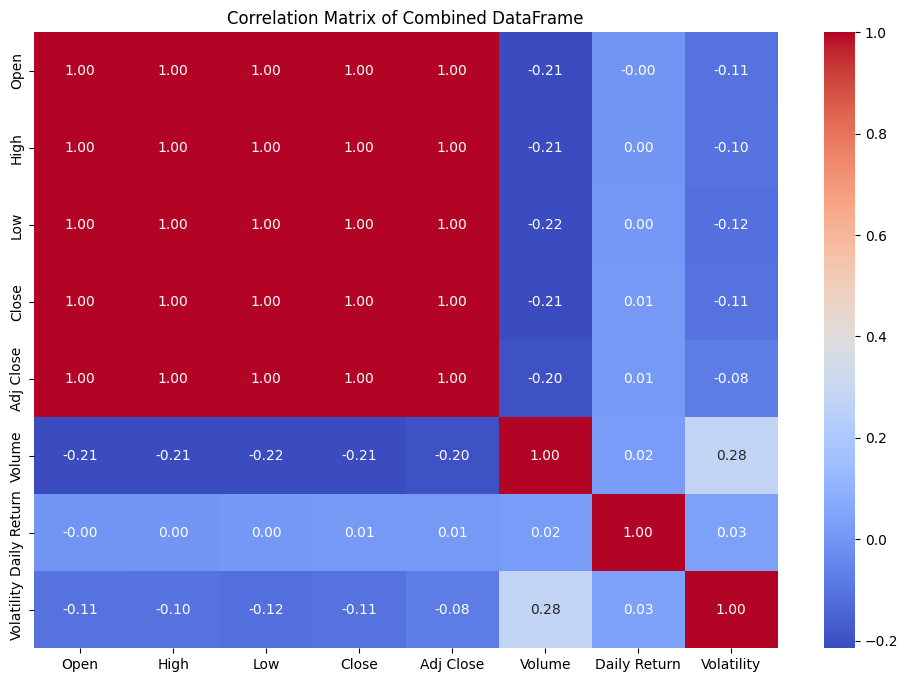

In [87]:
corr_matrix = X.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Combined DataFrame')
plt.show()

In [88]:
X = X.drop(columns=['Open','High','Low','Close'])

In [90]:
X.shape

(47061, 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [92]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 4)


In [93]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test)
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 389  108    0  100    0]
 [ 618  420    0  632    6]
 [   0    0   17    0    0]
 [1053  713    0 3195    3]
 [   2    0    8    0 2149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.65      0.29       597
           1       0.34      0.25      0.29      1676
           2       0.68      1.00      0.81        17
           3       0.81      0.64      0.72      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.66      9413
   macro avg       0.60      0.71      0.62      9413
weighted avg       0.73      0.66      0.68      9413

Accuracy: 0.6554764687134813


In [94]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[ 117   55    0  425    0]
 [  42  522    0 1112    0]
 [   0    0   17    0    0]
 [  81  269    0 4614    0]
 [   0    0    0    0 2159]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.20      0.28       597
           1       0.62      0.31      0.41      1676
           2       1.00      1.00      1.00        17
           3       0.75      0.93      0.83      4964
           4       1.00      1.00      1.00      2159

    accuracy                           0.79      9413
   macro avg       0.77      0.69      0.70      9413
weighted avg       0.77      0.79      0.76      9413

Accuracy: 0.7892276638691171


In [95]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  # Adjust scale_pos_weight as needed
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  90   62    0  444    1]
 [  34  449    0 1190    3]
 [   0    0    8    0    9]
 [  67  254    0 4641    2]
 [   0    3    5    2 2149]]

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.15      0.23       597
           1       0.58      0.27      0.37      1676
           2       0.62      0.47      0.53        17
           3       0.74      0.93      0.83      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.78      9413
   macro avg       0.68      0.56      0.59      9413
weighted avg       0.75      0.78      0.74      9413

Accuracy: 0.7794539466694996


# Maksed row prediction

## Base model (Replacing masked entry by column mean)

In [ ]:
# Function to create masked data
def create_masked_input(data, missing_rate=0.3, mask_value='mask'):
    """
    Mask a portion of the data to simulate missing features.

    Args:
        data (np.ndarray): Input data array.
        missing_rate (float): Proportion of features to mask.
        mask_value (float): Value to use for masking (e.g., np.inf or -np.inf).

    Returns:
        masked_data (np.ndarray): Data with missing features replaced by mask_value.
        mask (np.ndarray): Boolean mask indicating which features are missing.
    """
    
    mask = np.random.rand(*data.shape) > missing_rate
    masked_data = np.where(mask, data, mask_value)
    
    return masked_data, mask


In [ ]:
X = data
y = labels

X

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility
Date,,,,,,,,
2015-02-02,-0.851477,-0.850481,-0.854687,-0.850187,-0.820049,1.869345,0.601541,0.703267
2015-02-03,-0.850409,-0.850669,-0.851018,-0.850140,-0.820005,1.472904,-0.036302,0.596453
2015-02-04,-0.850409,-0.847331,-0.849339,-0.847980,-0.818042,2.140782,0.350216,0.593248
2015-02-05,-0.846801,-0.847989,-0.847084,-0.847078,-0.816200,1.118727,0.322811,0.586800
2015-02-06,-0.846801,-0.847942,-0.849003,-0.849475,-0.818388,1.172219,-0.478948,0.485124
...,...,...,...,...,...,...,...,...
2021-12-27,0.516812,0.531046,0.532393,0.545392,0.595792,-0.367933,1.060471,0.221783
2021-12-28,0.548617,0.534338,0.548704,0.536658,0.587085,-0.376378,-0.313374,0.165628
2021-12-29,0.537319,0.530105,0.545634,0.538082,0.588504,-0.384319,-0.001010,0.151610


In [98]:
y

Date
2015-02-02    4
2015-02-03    4
2015-02-04    4
2015-02-05    4
2015-02-06    4
             ..
2021-12-27    3
2021-12-28    3
2021-12-29    3
2021-12-30    1
2021-12-31    3
Name: Regime, Length: 47061, dtype: int32

In [99]:
num_zeros = (X == 0).sum().sum()
print(f"Number of 0 cells in X: {num_zeros}")

Number of 0 cells in X: 0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [101]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(X_train_resampled.shape)

(99275, 8)


In [102]:
def replace_masked_values_with_mean(X, mask_value='mask'):
    """
    Replace masked (masked_value) values with the column-wise mean.
    
    Args:
        X (np.ndarray): Input data array.
        mask_value: The value to be masked and replaced.

    Returns:
        np.ndarray: Data array with masked values replaced by column means.
    """
    # Ensure the input array is of type that can compare string values
    if isinstance(mask_value, str):
        X = np.array(X, dtype=object)

    # Create a mask where the value is equal to the mask_value
    mask = (X == mask_value)
    
    # Compute the column means, ignoring the mask_value
    col_means = []
    for i in range(X.shape[1]):
        valid_values = X[~mask[:, i], i]
        if valid_values.size > 0:
            valid_values = valid_values.astype(float)  # Convert valid entries to float
            col_means.append(valid_values.mean())
        else:
            col_means.append(0)  # Default mean if all values in the column are masked
    
    col_means = np.array(col_means)
    print("Column Means:", col_means)
    
    # Create a copy of the original data
    X_imputed = X.copy()
    
    # Impute the missing values (mask_value) with the column means
    for i in range(X.shape[1]):
        X_imputed[mask[:, i], i] = col_means[i]
    
    return X_imputed.astype(float)  # Ensure the final array is numeric


In [ ]:
# Mask the testing data
missing_rate = 0.4
X_test_masked, test_mask = create_masked_input(X_test, missing_rate=missing_rate)

# Replace masked values with column-wise mean
X_test_imputed = replace_masked_values_with_mean(X_test_masked)

Column Means: [-0.00995008 -0.0287205  -0.00560559 -0.01428621 -0.01698686 -0.01538561
  0.0180778  -0.00787693]


In [105]:
X_train_resampled.shape

(99275, 8)

In [106]:
X_test_imputed

array([[-0.00995008, -0.0287205 ,  0.46878141, ..., -0.01538561,
        -0.18916644, -0.00787693],
       [-0.00995008, -0.8883118 , -0.89114666, ...,  0.53569617,
         0.05719477, -0.00787693],
       [ 2.16700893,  2.21740329,  2.14811099, ..., -0.30917346,
         0.75247866, -0.00787693],
       ...,
       [-0.00995008, -0.0287205 ,  0.08077871, ..., -0.01538561,
         0.0180778 ,  0.02425371],
       [-0.00995008, -0.66052988, -0.6576159 , ..., -0.01538561,
         0.08959588, -0.00787693],
       [-0.00995008, -0.96834583, -0.00560559, ...,  0.17685431,
         0.3174824 ,  0.15659891]])

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred = log_reg.predict(X_test_imputed)

# Evaluate the model
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 301  259    0   36    1]
 [ 736  762    0  176    2]
 [   3    3    7    0    4]
 [1935 1941    0 1086    2]
 [ 514  448    5   17 1175]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.50      0.15       597
           1       0.22      0.45      0.30      1676
           2       0.58      0.41      0.48        17
           3       0.83      0.22      0.35      4964
           4       0.99      0.54      0.70      2159

    accuracy                           0.35      9413
   macro avg       0.54      0.43      0.40      9413
weighted avg       0.71      0.35      0.41      9413

Accuracy: 0.3538723042600659


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test_imputed)

evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  32   12    0  553    0]
 [  18  155    0 1503    0]
 [   0    0   11    2    4]
 [  36  106    0 4822    0]
 [  22   53    0  767 1317]]

Classification Report:
              precision    recall  f1-score   support

           0       0.30      0.05      0.09       597
           1       0.48      0.09      0.15      1676
           2       1.00      0.65      0.79        17
           3       0.63      0.97      0.76      4964
           4       1.00      0.61      0.76      2159

    accuracy                           0.67      9413
   macro avg       0.68      0.47      0.51      9413
weighted avg       0.67      0.67      0.61      9413

Accuracy: 0.6732178901519176


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test_imputed)

evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[ 110  171    0  316    0]
 [ 167  630    0  879    0]
 [   1    1    4    5    6]
 [ 421 1054    0 3487    2]
 [ 151  277    2  418 1311]]

Classification Report:
              precision    recall  f1-score   support

           0       0.13      0.18      0.15       597
           1       0.30      0.38      0.33      1676
           2       0.67      0.24      0.35        17
           3       0.68      0.70      0.69      4964
           4       0.99      0.61      0.75      2159

    accuracy                           0.59      9413
   macro avg       0.55      0.42      0.46      9413
weighted avg       0.65      0.59      0.61      9413

Accuracy: 0.5887602252204398


## Using Autoencoder embeddings learnt

In [ ]:
# Function to impute values based on learned embeddings
def impute_with_embeddings_model(model, X_masked, mask_value='mask'):
    """
    Impute masked values in the dataset using the reconstructed output from a trained autoencoder.

    Args:
        autoencoder_model (nn.Module): Trained autoencoder model.
        X_masked (np.ndarray): Dataset with masked values ('mask').
        mask_value: The value indicating masked entries.

    Returns:
        np.ndarray: Dataset with imputed values.
    """
    # Identify masked entries
    mask = (X_masked == mask_value)
    
    # Replace 'mask' with a placeholder value (e.g., 0) for tensor compatibility
    X_numeric = np.where(mask, 0, X_masked).astype(float)

    # Convert to PyTorch tensor
    X_tensor = torch.FloatTensor(X_numeric)
    
    # Ensure the autoencoder is in evaluation mode
    model.eval()

    with torch.no_grad():
        # Get reconstructed output
        if model in [Autoencoder_model, SimCLR_model]:
            embeddings, reconstructed = model(X_tensor)
            
        if model in [LSTM_model]:
            embeddings,reconstructed = model(X_tensor.unsqueeze(1))
            reconstructed = reconstructed.squeeze(1)
        
        print(embeddings.shape,reconstructed.shape)
        
        # Replace masked values with the corresponding values from the reconstruction
        reconstructed_np = reconstructed.numpy()
        X_imputed = X_numeric.copy()
        X_imputed[mask] = reconstructed_np[mask]
        return embeddings, X_imputed

In [112]:
Autoencoder_train_embeddings_torch = torch.tensor(Autoencoder_train_embeddings).float()
Autoencoder_train_embeddings_torch.shape

torch.Size([37648, 32])

In [113]:
print(X_train.shape, y_train.shape)

(37648, 8) (37648,)


In [114]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility
Date,,,,,,,,
2020-12-07,1.132704,1.164829,1.141837,1.129477,1.231870,-0.124233,1.164054,2.639256
2018-01-02,0.537889,0.541485,0.548416,0.555361,0.645903,-0.406398,0.678384,0.254991
2018-05-22,0.418356,0.405399,0.417643,0.404023,0.364531,-0.307692,-0.418183,-0.874581
2019-11-01,-0.569142,-0.571749,-0.565413,-0.569134,-0.548160,-0.363614,0.464335,-0.854902
2020-09-17,2.048331,2.057617,2.074713,2.070545,1.989753,-0.400307,-0.487292,-0.175093
...,...,...,...,...,...,...,...,...
2017-07-21,-0.905333,-0.905334,-0.906114,-0.905800,-0.881253,0.174981,-0.346347,-0.354157
2021-10-11,1.018773,1.052161,1.028718,1.018205,1.118301,-0.361947,-0.031343,0.160355
2020-11-05,0.013236,0.012000,0.019086,0.018463,0.059222,-0.327078,1.555745,0.333144


In [117]:
X_test_masked

array([['mask', 'mask', '0.4687814077069574', ..., 'mask',
        '-0.18916643934774724', 'mask'],
       ['mask', '-0.8883118008364503', '-0.8911466603991057', ...,
        '0.5356961710888082', '0.05719476663244477', 'mask'],
       ['2.167008925881267', '2.217403290839459', '2.148110989488955',
        ..., '-0.30917346394838463', '0.7524786646824694', 'mask'],
       ...,
       ['mask', 'mask', '0.08077871334859014', ..., 'mask', 'mask',
        '0.024253709411664225'],
       ['mask', '-0.6605298809145265', '-0.6576158980820483', ...,
        'mask', '0.08959588123326918', 'mask'],
       ['mask', '-0.9683458261449942', 'mask', ..., '0.1768543120075158',
        '0.31748240416549', '0.15659891280728302']], dtype='<U32')

In [ ]:
# Get imputed X_test and full embeddings
embeddings, X_test_imputed = impute_with_embeddings_model(Autoencoder_model,X_test_masked, mask_value='mask')
X_test = torch.tensor(X_test_imputed).float()
Autoencoder_test_embeddings_torch = torch.tensor(embeddings).float()

Autoencoder_test_embeddings_torch

torch.Size([9413, 32]) torch.Size([9413, 8])


tensor([[0.0000, 0.3165, 0.0000,  ..., 1.2522, 0.0000, 0.0000],
        [3.3482, 0.0000, 2.7171,  ..., 1.3681, 2.6830, 1.6545],
        [0.0000, 0.8020, 0.0000,  ..., 2.3257, 0.0000, 0.0000],
        ...,
        [0.2587, 0.3291, 0.0000,  ..., 1.2385, 0.1877, 0.1982],
        [1.7877, 0.1837, 1.3451,  ..., 1.8065, 2.0545, 0.8136],
        [2.0430, 0.0000, 1.7413,  ..., 0.2560, 1.2775, 1.5757]])

### Models on imputed X_test only

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 319  229    0   47    2]
 [ 756  653    0  265    2]
 [   3    1    9    0    4]
 [2003 1563    0 1395    3]
 [ 525  393    5   25 1211]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.53      0.15       597
           1       0.23      0.39      0.29      1676
           2       0.64      0.53      0.58        17
           3       0.81      0.28      0.42      4964
           4       0.99      0.56      0.72      2159

    accuracy                           0.38      9413
   macro avg       0.55      0.46      0.43      9413
weighted avg       0.70      0.38      0.45      9413

Accuracy: 0.3810687347285669


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test.numpy())

evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  40   17    0  540    0]
 [  29  187    0 1460    0]
 [   0    0   11    2    4]
 [  81  156    0 4727    0]
 [  28   61    0  750 1320]]

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.07      0.10       597
           1       0.44      0.11      0.18      1676
           2       1.00      0.65      0.79        17
           3       0.63      0.95      0.76      4964
           4       1.00      0.61      0.76      2159

    accuracy                           0.67      9413
   macro avg       0.66      0.48      0.52      9413
weighted avg       0.66      0.67      0.61      9413

Accuracy: 0.6676936152130033


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test.numpy())

evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[ 133  138    0  326    0]
 [ 234  577    0  864    1]
 [   1    1    4    5    6]
 [ 523  944    0 3495    2]
 [ 185  259    3  399 1313]]

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.22      0.16       597
           1       0.30      0.34      0.32      1676
           2       0.57      0.24      0.33        17
           3       0.69      0.70      0.70      4964
           4       0.99      0.61      0.75      2159

    accuracy                           0.59      9413
   macro avg       0.54      0.42      0.45      9413
weighted avg       0.65      0.59      0.61      9413

Accuracy: 0.5866355040900881


### Models on imputed X_test and embediings combined

In [123]:
concatenated_train_tensor = torch.cat((X_train_tensor, Autoencoder_train_embeddings_torch), dim=1)
concatenated_test_tensor = torch.cat((X_test_tensor, Autoencoder_test_embeddings_torch), dim=1)
print(concatenated_train_tensor.shape, concatenated_test_tensor.shape)

torch.Size([37648, 40]) torch.Size([9413, 40])


In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = log_reg.predict(concatenated_test_tensor.numpy())

evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 377  148    0   64    8]
 [ 863  532    0  268   13]
 [   0    0   10    0    7]
 [1893 1422    0 1634   15]
 [ 403  267    8    4 1477]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.63      0.18       597
           1       0.22      0.32      0.26      1676
           2       0.56      0.59      0.57        17
           3       0.83      0.33      0.47      4964
           4       0.97      0.68      0.80      2159

    accuracy                           0.43      9413
   macro avg       0.54      0.51      0.46      9413
weighted avg       0.71      0.43      0.49      9413

Accuracy: 0.42813130776585573


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = rf_model.predict(concatenated_test_tensor.numpy())

evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  16   16    0  564    1]
 [   6  114    0 1555    1]
 [   0    0   11    0    6]
 [  16   93    0 4849    6]
 [   0    0    0   12 2147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.03      0.05       597
           1       0.51      0.07      0.12      1676
           2       1.00      0.65      0.79        17
           3       0.69      0.98      0.81      4964
           4       0.99      0.99      0.99      2159

    accuracy                           0.76      9413
   macro avg       0.72      0.54      0.55      9413
weighted avg       0.71      0.76      0.68      9413

Accuracy: 0.7582067353659833


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = xgb_model.predict(concatenated_test_tensor.numpy())

evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  80  162    0  355    0]
 [ 113  555    0 1004    4]
 [   0    0    7    0   10]
 [ 226 1058    0 3677    3]
 [   0    3    1    1 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.13      0.16       597
           1       0.31      0.33      0.32      1676
           2       0.88      0.41      0.56        17
           3       0.73      0.74      0.74      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.69      9413
   macro avg       0.62      0.52      0.55      9413
weighted avg       0.68      0.69      0.68      9413

Accuracy: 0.6876659938383087


## Using LSTM encodings learnt

In [127]:
LSTM_train_embeddings_torch = torch.tensor(LSTM_train_embeddings).float()
LSTM_train_embeddings_torch.shape

torch.Size([37648, 64])

In [128]:
print(X_train.shape, y_train.shape)

(37648, 8) (37648,)


In [130]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility
Date,,,,,,,,
2020-12-07,1.132704,1.164829,1.141837,1.129477,1.231870,-0.124233,1.164054,2.639256
2018-01-02,0.537889,0.541485,0.548416,0.555361,0.645903,-0.406398,0.678384,0.254991
2018-05-22,0.418356,0.405399,0.417643,0.404023,0.364531,-0.307692,-0.418183,-0.874581
2019-11-01,-0.569142,-0.571749,-0.565413,-0.569134,-0.548160,-0.363614,0.464335,-0.854902
2020-09-17,2.048331,2.057617,2.074713,2.070545,1.989753,-0.400307,-0.487292,-0.175093
...,...,...,...,...,...,...,...,...
2017-07-21,-0.905333,-0.905334,-0.906114,-0.905800,-0.881253,0.174981,-0.346347,-0.354157
2021-10-11,1.018773,1.052161,1.028718,1.018205,1.118301,-0.361947,-0.031343,0.160355
2020-11-05,0.013236,0.012000,0.019086,0.018463,0.059222,-0.327078,1.555745,0.333144


In [ ]:
# X_test imputed and embeddings from LSTM model
embeddings, X_test_imputed = impute_with_embeddings_model(LSTM_model,X_test_masked, mask_value='mask')
X_test = torch.tensor(X_test_imputed).float()
LSTM_test_embeddings_torch = torch.tensor(embeddings).float()

LSTM_test_embeddings_torch

torch.Size([9413, 64]) torch.Size([9413, 8])


tensor([[-0.8340, -0.4546, -0.4433,  ..., -0.3011, -0.5738,  0.0949],
        [ 1.3326, -0.0700, -0.7338,  ...,  0.6375, -0.7418, -1.1679],
        [ 0.5628,  0.7459,  0.3960,  ...,  0.1326,  0.2207, -0.8833],
        ...,
        [ 0.1167, -0.0682,  0.4032,  ..., -0.2407, -0.2629, -0.1185],
        [-0.0032, -0.0210, -0.1851,  ..., -0.0285,  0.1032,  0.0930],
        [ 0.8719, -0.7049, -0.5956,  ..., -0.2326,  0.5511,  0.8713]])

### Models on X_test imputed only

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 298  255    0   42    2]
 [ 730  713    0  231    2]
 [   2    2    9    0    4]
 [1957 1752    0 1250    5]
 [ 501  443    5   16 1194]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.50      0.15       597
           1       0.23      0.43      0.29      1676
           2       0.64      0.53      0.58        17
           3       0.81      0.25      0.38      4964
           4       0.99      0.55      0.71      2159

    accuracy                           0.37      9413
   macro avg       0.55      0.45      0.42      9413
weighted avg       0.70      0.37      0.43      9413

Accuracy: 0.3680016997769043


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test.numpy())
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  29   11    0  557    0]
 [  20  145    0 1511    0]
 [   0    0   11    2    4]
 [  45   95    0 4824    0]
 [  19   52    0  771 1317]]

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.05      0.08       597
           1       0.48      0.09      0.15      1676
           2       1.00      0.65      0.79        17
           3       0.63      0.97      0.76      4964
           4       1.00      0.61      0.76      2159

    accuracy                           0.67      9413
   macro avg       0.67      0.47      0.51      9413
weighted avg       0.66      0.67      0.61      9413

Accuracy: 0.6720492935302241


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test.numpy())
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[ 106   98    0  392    1]
 [ 186  415    0 1074    1]
 [   1    1    5    5    5]
 [ 443  643    0 3873    5]
 [ 163  158    2  525 1311]]

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.18      0.14       597
           1       0.32      0.25      0.28      1676
           2       0.71      0.29      0.42        17
           3       0.66      0.78      0.72      4964
           4       0.99      0.61      0.75      2159

    accuracy                           0.61      9413
   macro avg       0.56      0.42      0.46      9413
weighted avg       0.64      0.61      0.61      9413

Accuracy: 0.6066078827153936


### Models on X_test imputed combined with embeddings

In [138]:
concatenated_train_tensor = torch.cat((X_train_tensor, Autoencoder_train_embeddings_torch), dim=1)
concatenated_test_tensor = torch.cat((X_test_tensor, Autoencoder_test_embeddings_torch), dim=1)
print(concatenated_train_tensor.shape, concatenated_test_tensor.shape)

torch.Size([37648, 40]) torch.Size([9413, 40])


In [139]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
# log_reg.fit(X_train_resampled, y_train_resampled)
log_reg.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = log_reg.predict(concatenated_test_tensor.numpy())

evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 377  148    0   64    8]
 [ 863  532    0  268   13]
 [   0    0   10    0    7]
 [1893 1422    0 1634   15]
 [ 403  267    8    4 1477]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.63      0.18       597
           1       0.22      0.32      0.26      1676
           2       0.56      0.59      0.57        17
           3       0.83      0.33      0.47      4964
           4       0.97      0.68      0.80      2159

    accuracy                           0.43      9413
   macro avg       0.54      0.51      0.46      9413
weighted avg       0.71      0.43      0.49      9413

Accuracy: 0.42813130776585573


In [140]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
# rf_model.fit(X_train_resampled, y_train_resampled)
rf_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = rf_model.predict(concatenated_test_tensor.numpy())
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  16   16    0  564    1]
 [   6  114    0 1555    1]
 [   0    0   11    0    6]
 [  16   93    0 4849    6]
 [   0    0    0   12 2147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.03      0.05       597
           1       0.51      0.07      0.12      1676
           2       1.00      0.65      0.79        17
           3       0.69      0.98      0.81      4964
           4       0.99      0.99      0.99      2159

    accuracy                           0.76      9413
   macro avg       0.72      0.54      0.55      9413
weighted avg       0.71      0.76      0.68      9413

Accuracy: 0.7582067353659833


In [141]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
# xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = xgb_model.predict(concatenated_test_tensor.numpy())
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  80  162    0  355    0]
 [ 113  555    0 1004    4]
 [   0    0    7    0   10]
 [ 226 1058    0 3677    3]
 [   0    3    1    1 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.13      0.16       597
           1       0.31      0.33      0.32      1676
           2       0.88      0.41      0.56        17
           3       0.73      0.74      0.74      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.69      9413
   macro avg       0.62      0.52      0.55      9413
weighted avg       0.68      0.69      0.68      9413

Accuracy: 0.6876659938383087


## Using SimCLR encodings learnt

In [142]:
SimCLR_train_embeddings_torch = torch.tensor(SimCLR_train_embeddings).float()
SimCLR_train_embeddings_torch.shape

torch.Size([37648, 64])

In [143]:
print(X_train.shape, y_train.shape)

(37648, 8) (37648,)


In [145]:
X_train

,Open,High,Low,Close,Adj Close,Volume,Daily Return,Volatility
Date,,,,,,,,
2020-12-07,1.132704,1.164829,1.141837,1.129477,1.231870,-0.124233,1.164054,2.639256
2018-01-02,0.537889,0.541485,0.548416,0.555361,0.645903,-0.406398,0.678384,0.254991
2018-05-22,0.418356,0.405399,0.417643,0.404023,0.364531,-0.307692,-0.418183,-0.874581
2019-11-01,-0.569142,-0.571749,-0.565413,-0.569134,-0.548160,-0.363614,0.464335,-0.854902
2020-09-17,2.048331,2.057617,2.074713,2.070545,1.989753,-0.400307,-0.487292,-0.175093
...,...,...,...,...,...,...,...,...
2017-07-21,-0.905333,-0.905334,-0.906114,-0.905800,-0.881253,0.174981,-0.346347,-0.354157
2021-10-11,1.018773,1.052161,1.028718,1.018205,1.118301,-0.361947,-0.031343,0.160355
2020-11-05,0.013236,0.012000,0.019086,0.018463,0.059222,-0.327078,1.555745,0.333144


In [148]:
X_test_masked

array([['mask', 'mask', '0.4687814077069574', ..., 'mask',
        '-0.18916643934774724', 'mask'],
       ['mask', '-0.8883118008364503', '-0.8911466603991057', ...,
        '0.5356961710888082', '0.05719476663244477', 'mask'],
       ['2.167008925881267', '2.217403290839459', '2.148110989488955',
        ..., '-0.30917346394838463', '0.7524786646824694', 'mask'],
       ...,
       ['mask', 'mask', '0.08077871334859014', ..., 'mask', 'mask',
        '0.024253709411664225'],
       ['mask', '-0.6605298809145265', '-0.6576158980820483', ...,
        'mask', '0.08959588123326918', 'mask'],
       ['mask', '-0.9683458261449942', 'mask', ..., '0.1768543120075158',
        '0.31748240416549', '0.15659891280728302']], dtype='<U32')

In [ ]:
# X_test imputed and embeddings learnt using SimCLR model
embeddings, X_test_imputed = impute_with_embeddings_model(SimCLR_model,X_test_masked, mask_value='mask')
X_test = torch.tensor(X_test_imputed).float()
SimCLR_test_encoddings = torch.tensor(embeddings).float()

SimCLR_test_encoddings

torch.Size([9413, 64]) torch.Size([9413, 8])


tensor([[-0.1062, -0.2752,  0.0381,  ..., -0.0258,  0.1209,  0.0390],
        [ 0.1285,  0.3402,  0.0450,  ..., -0.0693, -0.1181,  0.0566],
        [ 0.8203, -0.2521, -0.8088,  ..., -0.1490,  0.8101, -0.0160],
        ...,
        [ 0.0430, -0.4336, -0.0889,  ..., -0.0586,  0.0310,  0.0156],
        [-0.0122,  0.1477, -0.1289,  ...,  0.0614, -0.0994, -0.0358],
        [ 0.0921, -0.0848, -0.1383,  ..., -0.0288, -0.2187,  0.1570]])

### Models on X_test imputed only

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluate the model
evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 316  237    0   41    3]
 [ 751  687    0  235    3]
 [   1    1   11    0    4]
 [1991 1639    0 1330    4]
 [ 487  393    8    8 1263]]

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.53      0.15       597
           1       0.23      0.41      0.30      1676
           2       0.58      0.65      0.61        17
           3       0.82      0.27      0.40      4964
           4       0.99      0.58      0.74      2159

    accuracy                           0.38      9413
   macro avg       0.54      0.49      0.44      9413
weighted avg       0.71      0.38      0.45      9413

Accuracy: 0.3831934558589185


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test.numpy())
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  33   20    0  543    1]
 [  25  184    0 1466    1]
 [   0    0   11    2    4]
 [  71  160    0 4732    1]
 [  26   67    0  689 1377]]

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.06      0.09       597
           1       0.43      0.11      0.17      1676
           2       1.00      0.65      0.79        17
           3       0.64      0.95      0.76      4964
           4       0.99      0.64      0.78      2159

    accuracy                           0.67      9413
   macro avg       0.65      0.48      0.52      9413
weighted avg       0.66      0.67      0.62      9413

Accuracy: 0.6732178901519176


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test.numpy())
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[ 135  141    0  320    1]
 [ 240  549    0  885    2]
 [   0    1    5    1   10]
 [ 548  872    0 3541    3]
 [ 174  239    2  373 1371]]

Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.23      0.16       597
           1       0.30      0.33      0.32      1676
           2       0.71      0.29      0.42        17
           3       0.69      0.71      0.70      4964
           4       0.99      0.64      0.77      2159

    accuracy                           0.60      9413
   macro avg       0.56      0.44      0.47      9413
weighted avg       0.65      0.60      0.61      9413

Accuracy: 0.5950281525549772


### Models on X_test imputed combined with embeddings

In [155]:
concatenated_train_tensor = torch.cat((X_train_tensor, Autoencoder_train_embeddings_torch), dim=1)
concatenated_test_tensor = torch.cat((X_test_tensor, Autoencoder_test_embeddings_torch), dim=1)
print(concatenated_train_tensor.shape, concatenated_test_tensor.shape)

torch.Size([37648, 40]) torch.Size([9413, 40])


In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = log_reg.predict(concatenated_test_tensor.numpy())

evaluate_model(y_test, y_pred, "Logistic Regression")

Evaluation for Logistic Regression:
Confusion Matrix:
[[ 377  148    0   64    8]
 [ 863  532    0  268   13]
 [   0    0   10    0    7]
 [1893 1422    0 1634   15]
 [ 403  267    8    4 1477]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.63      0.18       597
           1       0.22      0.32      0.26      1676
           2       0.56      0.59      0.57        17
           3       0.83      0.33      0.47      4964
           4       0.97      0.68      0.80      2159

    accuracy                           0.43      9413
   macro avg       0.54      0.51      0.46      9413
weighted avg       0.71      0.43      0.49      9413

Accuracy: 0.42813130776585573


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = rf_model.predict(concatenated_test_tensor.numpy())
evaluate_model(y_test, y_pred, "Random Forest")

Evaluation for Random Forest:
Confusion Matrix:
[[  16   16    0  564    1]
 [   6  114    0 1555    1]
 [   0    0   11    0    6]
 [  16   93    0 4849    6]
 [   0    0    0   12 2147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.03      0.05       597
           1       0.51      0.07      0.12      1676
           2       1.00      0.65      0.79        17
           3       0.69      0.98      0.81      4964
           4       0.99      0.99      0.99      2159

    accuracy                           0.76      9413
   macro avg       0.72      0.54      0.55      9413
weighted avg       0.71      0.76      0.68      9413

Accuracy: 0.7582067353659833


In [ ]:
xgb_model = XGBClassifier(eval_metric='mlogloss', enable_categorical=True, random_state=42)  
xgb_model.fit(concatenated_train_tensor.numpy(), y_train)
y_pred = xgb_model.predict(concatenated_test_tensor.numpy())
evaluate_model(y_test, y_pred, "XGBoost")

Evaluation for XGBoost:
Confusion Matrix:
[[  80  162    0  355    0]
 [ 113  555    0 1004    4]
 [   0    0    7    0   10]
 [ 226 1058    0 3677    3]
 [   0    3    1    1 2154]]

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.13      0.16       597
           1       0.31      0.33      0.32      1676
           2       0.88      0.41      0.56        17
           3       0.73      0.74      0.74      4964
           4       0.99      1.00      0.99      2159

    accuracy                           0.69      9413
   macro avg       0.62      0.52      0.55      9413
weighted avg       0.68      0.69      0.68      9413

Accuracy: 0.6876659938383087
